# instal and import

In [ ]:
!pip install keras_tuner

In [15]:
import yfinance as yf
from  sklearn.preprocessing  import MinMaxScaler
import keras
import numpy as np
from keras.layers import SimpleRNN, LSTM, GRU  , Dense
import keras_tuner
import matplotlib.pyplot as plt

# DATA GOOGLE

In [16]:
ms = yf.download(
    'GOOG',
    start='2000-01-01',
    end='2023-11-30',
    progress=False
)

In [17]:
ms

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2023-11-22,139.100006,141.100006,139.000000,140.020004,140.020004,17306400
2023-11-24,139.539993,139.677002,137.470001,138.220001,138.220001,8828600
2023-11-27,137.570007,139.630005,137.539993,138.050003,138.050003,17886400


In [18]:
df = ms[['Open', 'High', 'Low', 'Close', 'Adj Close']].round(3)

In [19]:
shape=df.shape[0]
shape

4854

In [20]:
train_shape= round((80*shape)/100)
train_shape


3883

In [21]:
tran_data = df[:train_shape]
tran_data.shape

(3883, 5)

In [22]:

def ts_data(df, X_step, y_step):
    # test_size = 20 & train_size=80
    shape=df.shape[0]
    train_shape= round((80*shape)/100)
    train_data =  df[:train_shape].Close.values.reshape(-1, 1)
    test_data = df[train_shape:].Close.values.reshape(-1,1)

    sc = MinMaxScaler(feature_range=(0,1))
    train_df_scaled = sc.fit_transform(train_data)

    X_train = []
    y_train = []

    for i in range(X_step, len(train_df_scaled)-y_step+1):
        X_train.append(train_df_scaled[i-X_step:i, 0])
        y_train.append(train_df_scaled[i:i+y_step, 0])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    # print(X_train.shape)
    X = df.Close.values
    X = X[len(X)-len(test_data)-X_step:]
    X = X.reshape(-1, 1)
    X = sc.transform(X)

    X_test = []
    y_test = []

    for i in range(X_step, len(test_data)+X_step-y_step):
      X_test.append(X[i-X_step:i, 0])
      y_test.append(X[i:i+y_step, 0])

    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test, sc


In [23]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 8, 2)
X_test.shape


(969, 8, 1)

# Plot Function

In [44]:
def prediction_plot_train_data(predictions):
  fig, ax = plt.subplots()
  ax.plot(df[:train_shape].index[:len(y_train)],
          sc.inverse_transform(y_train[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df[:train_shape].index[:len(y_train)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")

In [33]:

def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df[train_shape:].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df[train_shape:].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")

# MODEL

## Simple_RNN

In [58]:
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            SimpleRNN(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                             return_sequences=True
            )
        )

    model.add(SimpleRNN(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
    model.add(Dense(2))
    # learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer='adam',
        loss="mean_absolute_error",
        metrics=["accuracy"],
    )
    return model


model_step_1 = build_model(keras_tuner.HyperParameters())

In [61]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)

model_step_1.fit(X_train, y_train, epochs=100, validation_split=0.15,  callbacks=[callback])

Epoch 1/100
103/103 [==============================] - 1s 8ms/step - loss: 0.0050 - accuracy: 0.5043 - val_loss: 0.0140 - val_accuracy: 0.4691
Epoch 2/100
103/103 [==============================] - 1s 10ms/step - loss: 0.0052 - accuracy: 0.5000 - val_loss: 0.0147 - val_accuracy: 0.4674
Epoch 3/100
103/103 [==============================] - 1s 8ms/step - loss: 0.0047 - accuracy: 0.4948 - val_loss: 0.0122 - val_accuracy: 0.5292
Epoch 4/100
103/103 [==============================] - 1s 9ms/step - loss: 0.0045 - accuracy: 0.4970 - val_loss: 0.0146 - val_accuracy: 0.5309
Epoch 5/100
103/103 [==============================] - 1s 11ms/step - loss: 0.0046 - accuracy: 0.5012 - val_loss: 0.0139 - val_accuracy: 0.5344
Epoch 6/100
103/103 [==============================] - 1s 11ms/step - loss: 0.0047 - accuracy: 0.4912 - val_loss: 0.0120 - val_accuracy: 0.4897
Epoch 7/100
103/103 [==============================] - 1s 9ms/step - loss: 0.0046 - accuracy: 0.4991 - val_loss: 0.0120 - val_accuracy: 0.4

31/31 [==============================] - 0s 4ms/step


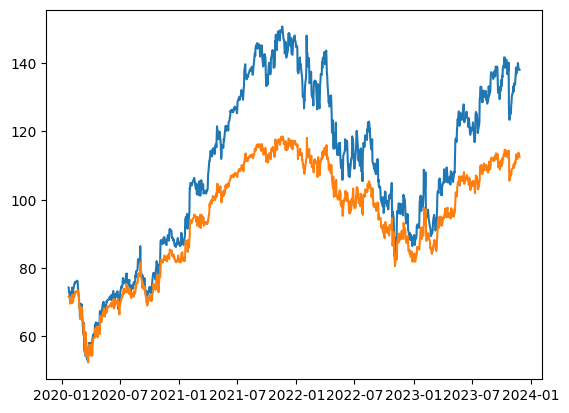

In [62]:
model_pred = model_step_1.predict(X_test)
prediction_plot(model_pred)

#### plot train data

122/122 [==============================] - 0s 3ms/step


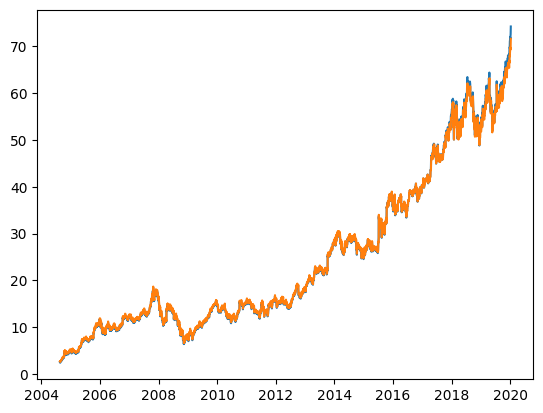

In [63]:
model_pred_GRU_LSTM  = model_step_1.predict(X_train)
prediction_plot_train_data(model_pred_GRU_LSTM)

## LSTM

In [52]:
def build_model_LSTM(hp):
    model = keras.Sequential()

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            LSTM(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                             return_sequences=True
            )
        )

    model.add(SimpleRNN(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
    model.add(Dense(2))
    # learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer='adam',
        loss="mean_absolute_error",
        metrics=["accuracy"],
    )
    return model


model_step_2 = build_model_LSTM(keras_tuner.HyperParameters())

In [55]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model_step_2.fit(X_train, y_train, epochs=100, validation_split=0.15,  callbacks=[callback])

Epoch 1/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0044 - accuracy: 0.5000 - val_loss: 0.0151 - val_accuracy: 0.4708
Epoch 2/100
103/103 [==============================] - 2s 20ms/step - loss: 0.0044 - accuracy: 0.4973 - val_loss: 0.0139 - val_accuracy: 0.4931
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0044 - accuracy: 0.4869 - val_loss: 0.0112 - val_accuracy: 0.4742
Epoch 4/100
103/103 [==============================] - 1s 10ms/step - loss: 0.0044 - accuracy: 0.5070 - val_loss: 0.0133 - val_accuracy: 0.4725
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0042 - accuracy: 0.5049 - val_loss: 0.0126 - val_accuracy: 0.4674
Epoch 6/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0047 - accuracy: 0.5049 - val_loss: 0.0122 - val_accuracy: 0.4742
Epoch 7/100
103/103 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 0.5018 - val_loss: 0.0137 - val_accuracy:

#### plot test data

31/31 [==============================] - 0s 3ms/step


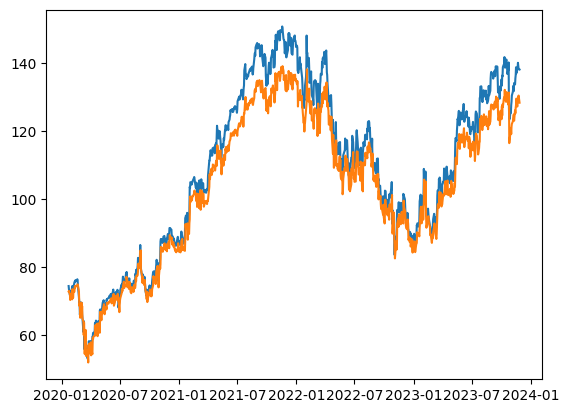

In [56]:
model_pred = model_step_2.predict(X_test)

prediction_plot(model_pred)

#### plot train data

122/122 [==============================] - 0s 4ms/step


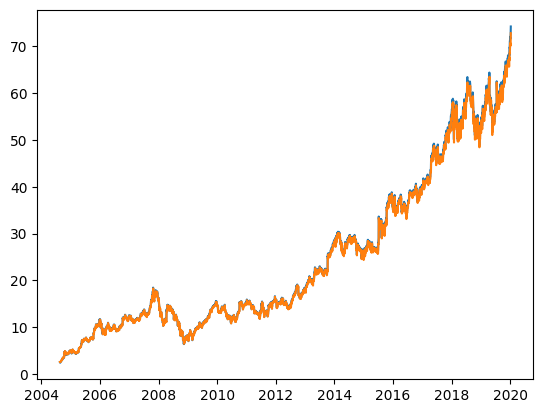

In [57]:
model_pred_GRU_LSTM  = model_step_2.predict(X_train)
prediction_plot_train_data(model_pred_GRU_LSTM)

In [64]:
"""
نتیجه استفاده از LSTM
نسبت به RNN
بهتر میباشد.
"""

## GRU




In [47]:
def build_model_GRU(hp):
    model = keras.Sequential()

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            GRU(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                             return_sequences=True
            )
        )

    model.add(SimpleRNN(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
    model.add(Dense(2))
    # learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer='adam',
        loss="mean_absolute_error",
        metrics=["accuracy"],
    )
    return model


model_step_3 = build_model_GRU(keras_tuner.HyperParameters())

In [49]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model_step_3.fit(X_train, y_train, epochs=100, validation_split=0.15,  callbacks=[callback])

Epoch 1/100
103/103 [==============================] - 3s 26ms/step - loss: 0.0248 - accuracy: 0.4973 - val_loss: 0.0864 - val_accuracy: 0.5326
Epoch 2/100
103/103 [==============================] - 1s 8ms/step - loss: 0.0091 - accuracy: 0.4894 - val_loss: 0.0618 - val_accuracy: 0.5275
Epoch 3/100
103/103 [==============================] - 1s 8ms/step - loss: 0.0076 - accuracy: 0.5036 - val_loss: 0.0452 - val_accuracy: 0.5120
Epoch 4/100
103/103 [==============================] - 1s 8ms/step - loss: 0.0070 - accuracy: 0.4793 - val_loss: 0.0213 - val_accuracy: 0.4811
Epoch 5/100
103/103 [==============================] - 1s 9ms/step - loss: 0.0063 - accuracy: 0.5039 - val_loss: 0.0224 - val_accuracy: 0.4639
Epoch 6/100
103/103 [==============================] - 1s 11ms/step - loss: 0.0064 - accuracy: 0.4954 - val_loss: 0.0157 - val_accuracy: 0.4811
Epoch 7/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0059 - accuracy: 0.4982 - val_loss: 0.0169 - val_accuracy: 0.5

#### plot test data

31/31 [==============================] - 1s 3ms/step


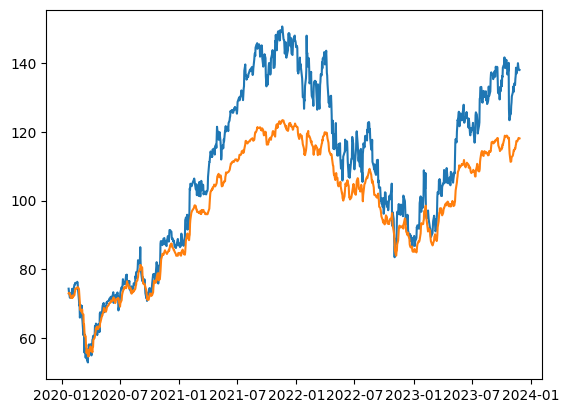

In [50]:
model_pred_GRU = model_step_3.predict(X_test)
prediction_plot(model_pred_GRU)

#### plot train data

122/122 [==============================] - 0s 4ms/step


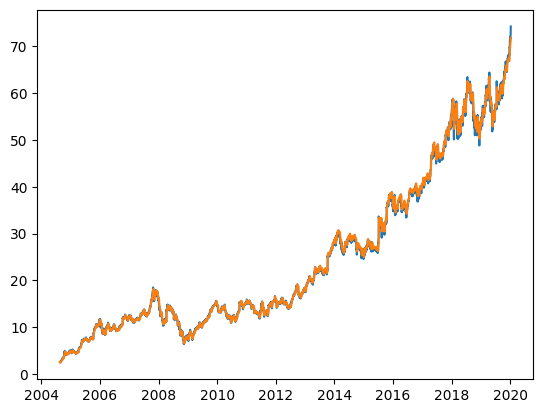

In [51]:
model_pred_GRU_LSTM  = model_step_3.predict(X_train)
prediction_plot_train_data(model_pred_GRU_LSTM)

In [ ]:
"""

نتیجه استفاده از GRU
نسبت به RNN
بهتر میباشد.

ولی نسبت به LSTM
بهتر نیست.
"""

## GRU & LSTM




In [27]:
model = keras.Sequential()

model_step_4 = keras.Sequential([
    GRU(50,return_sequences=True) ,
    GRU(50,return_sequences=True),
    LSTM(100,return_sequences=True),
    LSTM(100),
    Dense(2)]
    )

# model.add(SimpleRNN(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
# model.add(Dense(2))
# learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
model_step_4.compile(
    optimizer='adam',
    loss="mean_absolute_error",
    metrics=["accuracy"],
)



In [29]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10 )

model_step_4.fit(X_train, y_train, epochs=100, validation_split=0.15,  callbacks=[callback])

Epoch 1/100
103/103 [==============================] - 10s 95ms/step - loss: 0.0063 - accuracy: 0.4970 - val_loss: 0.0127 - val_accuracy: 0.4674
Epoch 2/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0056 - accuracy: 0.5125 - val_loss: 0.0144 - val_accuracy: 0.4674
Epoch 3/100
103/103 [==============================] - 3s 32ms/step - loss: 0.0055 - accuracy: 0.5058 - val_loss: 0.0150 - val_accuracy: 0.5344
Epoch 4/100
103/103 [==============================] - 4s 43ms/step - loss: 0.0057 - accuracy: 0.5067 - val_loss: 0.0133 - val_accuracy: 0.4759
Epoch 5/100
103/103 [==============================] - 3s 32ms/step - loss: 0.0058 - accuracy: 0.4936 - val_loss: 0.0261 - val_accuracy: 0.5344
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.0049 - accuracy: 0.4857 - val_loss: 0.0135 - val_accuracy: 0.4674
Epoch 7/100
103/103 [==============================] - 4s 35ms/step - loss: 0.0048 - accuracy: 0.5191 - val_loss: 0.0163 - val_accuracy

#### plot test data

31/31 [==============================] - 0s 10ms/step


31/31 [==============================] - 0s 12ms/step


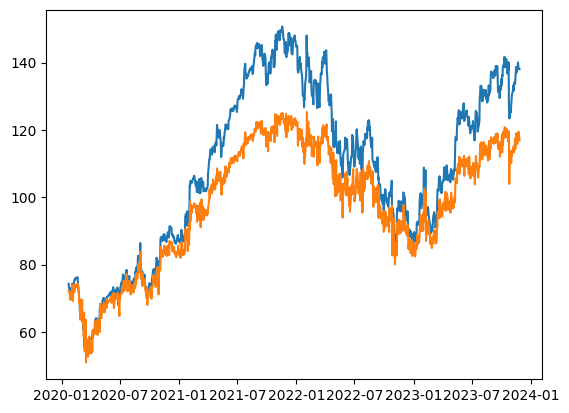

In [46]:
model_pred_GRU_LSTM  = model_step_4.predict(X_test)
prediction_plot(model_pred_GRU_LSTM)

#### plot train validation  data

122/122 [==============================] - 2s 16ms/step


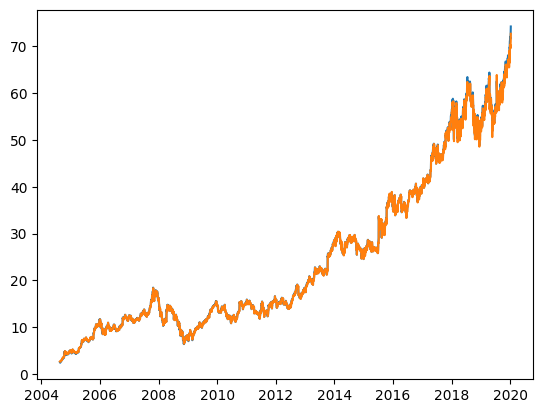

In [45]:
model_pred_GRU_LSTM  = model_step_4.predict(X_train)
prediction_plot_train_data(model_pred_GRU_LSTM)

In [ ]:

"""
نتیجه استفاده از LSTM , GRU
نسبت به RNN
بهتر میباشد.

و نسبت به LSTM
بهتر نیست
"""

In [ ]:
#  با تشکر